# Generalized wavelets

Yanghua Wang (2015). Generalized seismic wavelets. _Geophysical Journal International_ **203** (2), pp 1172–1178, https://doi.org/10.1093/gji/ggv346

In [1]:
import numpy as np
from collections import namedtuple


def generalized_wavelet(duration, dt, f, u=2, return_t=False, center=True, imag=False):
    """
    Wang's generalized wavelet, of which the Ricker is a special case where u = 2.
    The parameter u is the order of the time-domain derivative, which can be a
    fractional derivative.

    As given by Wang (2015), Generalized seismic wavelets. GJI 203, p 1172-78.
    DOI: https://doi.org/10.1093/gji/ggv346. I am using the (more accurate)
    frequency domain method (eq 4 in that paper).

    Args:
        duration (float): The length of the wavelet, in s.
        dt (float): The time sample interval in s.
        f (float or array-like): The frequency or frequencies, in Hertz.
        u (float or array-like): The fractional derivative parameter u.
        return_t (bool): Whether to return the time basis array.
        center (bool): Whether to center the wavelet on time 0.
        imag (bool): Whether to return the imaginary component as well.

    Returns:
        ndarray. If f and u are floats, the resulting wavelet has duration/dt
            = A samples. If you give f as an array of length M and u as an array
            of length N, then the resulting wavelet bank will have shape (M, N, A).
            If f or u are floats, their size will be 1, and they will be squeezed
            out: the bank is always squeezed to its minimum number of dimensions.
    """
    # Make sure we can do banks.
    f = np.asanyarray(f).reshape(-1, 1)
    u = np.asanyarray(u).reshape(-1, 1, 1)

    # Basics.
    om0 = f * 2 * np.pi
    u2 = u / 2
    df = 1 / duration
    nyquist = (1 / dt) / 2
    nf = 1 + nyquist / df
    t0 = duration / 2
    om = 2 * np.pi * np.arange(0, nyquist, df)

    # Compute the spectrum from Wang's eq 4.
    exp1 = np.exp((-om**2 / om0**2) + u2)
    exp2 = np.exp(-1j*om*t0 + 1j*np.pi * (1 + u2))
    W = (u2**(-u2)) * (om**u / om0**u) * exp1 * exp2

    # Compute time domain response.
    if center:
        t = np.arange(-duration/2, duration/2, dt)
    else:
        t = np.arange(0, duration, dt)
    w = np.fft.ifft(W, t.size)
    if not imag:
        w = w.real

    # At this point the wavelet bank has the shape (u, f, a),
    # where u is the size of u, f is the size of f, and a is
    # the number of amplitude samples we generated.
    w_max = np.max(np.abs(w), axis=-1)[:, :, None]
    w = np.squeeze(w / w_max)

    if return_t:
        GeneralizedWavelet = namedtuple('GeneralizedWavelet', ['amplitude', 'time'])
        return GeneralizedWavelet(w, t)
    else:
        return w


In [2]:
params = {'duration': 0.1, 'dt': 0.001, 'f': 30}

u = np.arange(0.4, 2.4, 0.2)

bank, t = generalized_wavelet(**params, u=u, return_t=True, center=False)

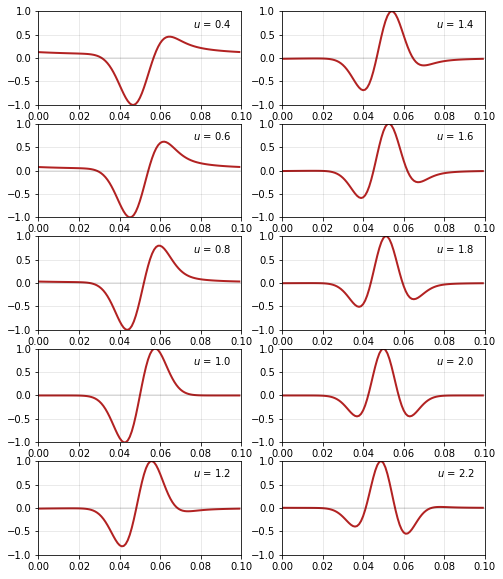

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=2,
                        figsize=(8, 10),
                        # sharex=True, sharey=True,
                       )

for ax, w, u_i in zip(axs.T.ravel(), bank, u):
    ax.plot(t, w, 'firebrick', lw=2)
    ax.set_ylim(-1, 1)
    ax.set_xlim(0, 0.1)
    ax.text(0.095, 0.65, f"$u$ = {u_i:.1f}", ha='right')
    ax.grid(c='k', alpha=0.1)
    ax.axhline(0, c='k', alpha=0.1, lw=1.5)